In [102]:
import requests
import pandas as pd

# Load API key from file
with open("api_key.txt") as f:
    API_KEY = f.read().strip()
    print(API_KEY)

# Build URL
#url = f"https://api.eia.gov/v2/seriesid/PET.RWTC.D?API_KEY={API_KEY}"
url = f"https://api.eia.gov/v2/petroleum/pri/spt/data?api_key=hER03UGh220dC476aGcSfw0za1RO8ajsWwpwEnFZ&frequency=daily&data[]=value&facets[duoarea][]=Y35NY&facets[process][]=PF4&facets[product][]=EPMRU&facets[series][]=EER_EPMRU_PF4_Y35NY_DPG"

# Fetch data
response = requests.get(url)
data_json = response.json()

# Check structure
print(data_json.keys())

# Check for error
if "error" in data_json:
    print("API error:", data_json["error"])
else:
    data = data_json["response"]["data"]
    df = pd.DataFrame(data)
    print(df.head())


AttributeError: 'str' object has no attribute 'datatype'

In [95]:
# Reorganize dataframe with relievant data
df = df[["period", "value", "units"]].copy()

# Convert period to pandas datetime format
df["period"] = pd.to_datetime(df["period"])
df.rename(columns={"period": "Date", "value": "Price", "units": "Unit"}, inplace=True)


print(df.shape)
print(df.head())
print(df.tail())

(5000, 3)
        Date  Price   Unit
0 2024-09-05  2.039  $/GAL
1 2024-04-09  2.748  $/GAL
2 2024-04-11  2.756  $/GAL
3 2024-07-05  2.579  $/GAL
4 2025-07-07  2.174  $/GAL
           Date Price   Unit
4995 1987-08-06  .545  $/GAL
4996 1987-08-11  .546  $/GAL
4997 1987-08-31  .504  $/GAL
4998 1987-09-04  .508  $/GAL
4999 1987-09-18  .528  $/GAL


In [96]:
print(df["Price"].max())
print(df["Price"].min())

df["Price"] = pd.to_numeric(df["Price"], errors="coerce").astype(float)
df["Price"] = df["Price"].round(3)

print(df.head(20))

print(df["Price"].max())
print(df["Price"].min())

4.442
.293
         Date  Price   Unit
0  2024-09-05   2.04  $/GAL
1  2024-04-09   2.75  $/GAL
2  2024-04-11   2.76  $/GAL
3  2024-07-05   2.58  $/GAL
4  2025-07-07   2.17  $/GAL
5  2025-04-17   1.91  $/GAL
6  2024-02-14   2.33  $/GAL
7  2025-05-15   1.97  $/GAL
8  2024-01-17   2.20  $/GAL
9  2024-02-08   2.36  $/GAL
10 2025-04-22   1.95  $/GAL
11 2024-12-13   2.07  $/GAL
12 2024-12-16   2.05  $/GAL
13 2025-03-26   2.05  $/GAL
14 2025-03-27   2.06  $/GAL
15 2024-12-04   2.08  $/GAL
16 2024-12-09   2.03  $/GAL
17 2024-10-21   2.12  $/GAL
18 2025-02-14   2.16  $/GAL
19 2024-09-12   2.05  $/GAL
4.44
0.29


NameError: name 'window' is not defined

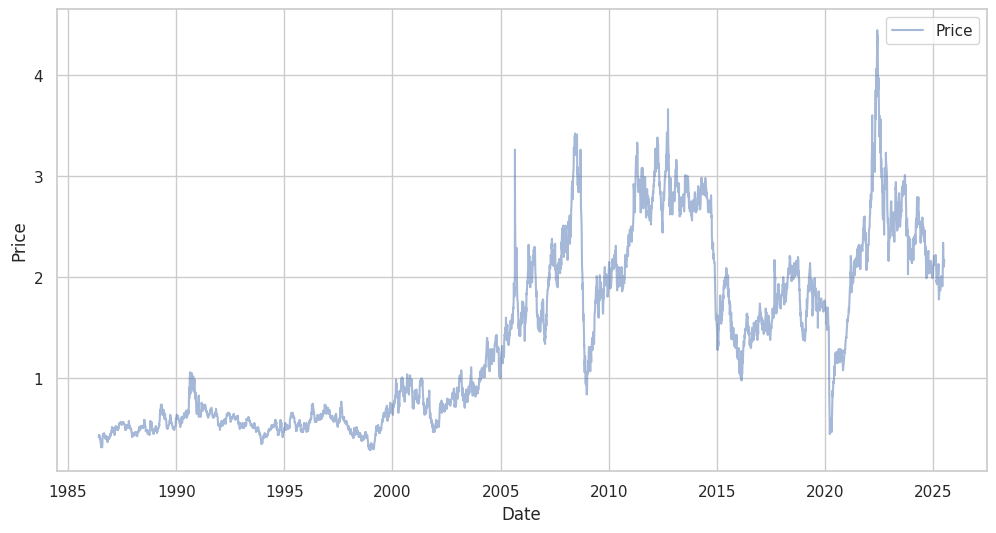

In [97]:
import matplotlib.dates as mdates
from matplotlib.ticker import MaxNLocator
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(12,6))

sns.lineplot(data=df, x="Date", y="Price", ax=ax, alpha=0.5, label="Price")
sns.lineplot(data=df, x="Date", y="RollingAvg", ax=ax, color="red", label=f"{window}-day Avg")

# X-axis every 2 years
ax.xaxis.set_major_locator(mdates.YearLocator(2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
fig.autofmt_xdate()
ax.yaxis.set_major_locator(MaxNLocator(nbins=2, prune=None))

# Y-axis tight range with about 10 ticks
low = df["Price"].min() * 0.95
high = df["Price"].max() * 1.05
ax.set_ylim(low, high)
ax.yaxis.set_major_locator(MaxNLocator(nbins=.5, prune=None))

# Titles
ax.set_title(f"{option} Price Over Time")
ax.set_xlabel("Date")
ax.set_ylabel(f"Price ({unit_label})")
ax.legend()

st.pyplot(fig)
print(df.head())

In [ ]:
import requests
import pandas as pd
import streamlit as st
import matplotlib.pyplot as plt
import seaborn as sns

# Load API key from file
with open("api_key.txt") as f:
    API_KEY = f.read().strip()

# Commodity dictionary
COMMODITIES = {
    "WTI Crude Oil": "seriesid/PET.RWTC.D",
    "Brent Crude Oil": "seriesid/PET.RBRTE.D",
    "Henry Hub Natural Gas": "seriesid/NG.RNGWHHD.D",
    "NY Petroleum": "petroleum/pri/spt/data",
    "Heating Oil": "PET.EMD_EPD2D_PTE_NUS_DPG.D",
    "Diesel": "PET.EMD_EPD2DXL0_PTE_NUS_DPG.D",
    "U.S. Gasoline Avg": "PET.EMD_EPMR_PTE_NUS_DPG.D"
}

# Select box on dashboard
option = st.selectbox(
    "Choose commodity data to display",
    list(COMMODITIES.keys())
)
st.write(f"You selected: {option}")
series_id = COMMODITIES[option]

# Build URL
if option in ["WTI Crude Oil", "Brent Crude Oil", "Henry Hub Natural Gas"]:
    url = f"https://api.eia.gov/v2/{series_id}?api_key={API_KEY}"
elif option == "NY Petroleum":
    facets = ("frequency=daily&data[]=value"
              "&facets[duoarea][]=Y35NY"
              "&facets[process][]=PF4"
              "&facets[product][]=EPMRU"
              "&facets[series][]=EER_EPMRU_PF4_Y35NY_DPG")
    url = f"https://api.eia.gov/v2/{series_id}?api_key={API_KEY}&{facets}"

# Fetch data
response = requests.get(url)
data_json = response.json()

# Check for error
if "error" in data_json:
    st.error(f"API error: {data_json['error']}")
    st.stop()
else:
    data = data_json["response"]["data"]
    df = pd.DataFrame(data)

# Reorganize dataframe
df = df[["period", "value", "units"]].copy()
df["period"] = pd.to_datetime(df["period"])
df.rename(columns={"period": "Date", "value": "Price", "units": "Unit"}, inplace=True)
df = df.sort_values("Date")

# If NY Petroleum, convert and round Price to nearest tenth
if option == "NY Petroleum":
    df["Price"] = pd.to_numeric(df["Price"], errors="coerce").astype(float)
    df["Price"] = df["Price"].round(3)

# Sort date
df = df.sort_values("Date")

# Streamlit dashboard
st.title("Supply Chain Dashboard")
st.write("Data automatically updated from EIA API")

# Rolling average window
window = st.slider(label="Rolling Average Window:", min_value=1, max_value=100, value=50)
df["RollingAvg"] = df["Price"].rolling(window=window).mean()

# Build figure using seaborn
sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(12,6))
sns.lineplot(data=df, x="Date", y="Price", color="green", ax=ax, alpha=0.5, label="Price")
sns.lineplot(data=df, x="Date", y="RollingAvg", color="red", label=f"{window}-day Avg", ax=ax)

# Labels
ax.set_title(f"{option} Price Over Time")
ax.set_xlabel("Date")
unit_label = df["Unit"].iloc[0]
ax.set_ylabel(f"Price ({unit_label})")
ax.legend()

# Plot data
st.pyplot(fig)

# Add df preview of the last 20 entries
st.subheader("Latest 5 Data Points")
st.write(df.sort_values("Date", ascending=False).head(20))